<a href="https://colab.research.google.com/drive/1YAkxWG0dRKPtqy9CZxFPvCNCCXvMGr65?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Описание задачи и концепт FusionBrain**

*В качестве демонстрации концепции соревнования FusionBrain (FB) предлагается решить задачу объединения нескольких модальностей в одну единую модель:*

+ [audio] задача классификации эмоций речи человека [RAVDESS](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0196391)
+ [image] задача распознавания рукописного текста [(одна из задач соревнования FB)](https://github.com/sberbank-ai/fusion_brain_aij2021)
+ [text] задача классификации [сентимента твиттов на тему COVID-19](https://www.kaggle.com/datatattle/covid-19-nlp-text-classification)


*Основные моменты решения, связанные с концепцией FB:*

+ Используется языковая предобученная GPT2 [text] для анализа новых типов модальностей, которые ранее модель для обучения не использовала [image][audio]
+ Предложенные задачи решаются архитектурно единой моделью
+ Общая часть SharedWeights, которая используется для ВСЕХ модальностей, не менее 80% (от участников ожидается на 4 задачах не менее 30%)
+ Для backpropagation используется мультимодальный минибатч


*Авторы:*

+ [Alex Shonenkov](https://www.kaggle.com/shonenkov) (Sber AI)
+ Denis Dimitrov (Sber AI)
+ [Daria Bakshandaeva](https://github.com/Gugutse) (Sber AI)



In [ ]:
#@title Доступные ресурсы
import multiprocessing
import torch
from psutil import virtual_memory

ram_gb = round(virtual_memory().total / 1024**3, 1)

print('CPU:', multiprocessing.cpu_count())
print('RAM GB:', ram_gb)
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device.type)

!nvidia-smi

CPU: 2
RAM GB: 12.7
PyTorch version: 1.9.0+cu102
CUDA version: 10.2
cuDNN version: 7605
device: cuda
Sat Sep 18 11:50:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+-----------

In [ ]:
#@title Установка зависимостей
!git clone https://github.com/sberbank-ai/fusion_brain_aij2021.git
!pip install tpu_star==0.0.1rc10 > /dev/null
!pip install albumentations==0.5.2 > /dev/null
!pip install einops==0.3.2 > /dev/null
!pip install torchaudio==0.9.0 > /dev/null
!pip install transformers==4.10.0 > /dev/null
!pip install speechaugs==0.0.11 --no-deps > /dev/null
!pip install colorednoise==1.1.1 > /dev/null
!pip install catalyst==21.8 > /dev/null

Cloning into 'fusion_brain_aij2021'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 115 (delta 31), reused 12 (delta 0), pack-reused 0
Receiving objects: 100% (115/115), 342.21 KiB | 2.63 MiB/s, done.
Resolving deltas: 100% (31/31), done.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
speechaugs 0.0.11 requires librosa<=0.8.0,>=0.6.1, but you have librosa 0.8.1 which is incompatible.


In [ ]:
#@title Импорты зависимостей
import torchaudio
torchaudio.set_audio_backend('sox_io')

import json
import random
import cv2
import torch
import speechaugs
import pandas as pd
import numpy as np
import albumentations as A
import IPython.display as ipd
from collections import defaultdict
from glob import glob
from datetime import datetime
from skimage import io
from torch import nn
from tqdm import tqdm
from einops import rearrange
from sklearn.metrics import accuracy_score
from catalyst.data import BalanceClassSampler
from transformers import GPT2Model, GPT2Tokenizer
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset, DataLoader, SequentialSampler, RandomSampler
from torch.nn.utils.rnn import pad_sequence
from tpu_star.experiment import TorchGPUExperiment

import sys
sys.path.insert(0, 'fusion_brain_aij2021/fb_concept')
from fb_utils.download import download_and_extract
from fb_utils.sentiment import clean_text
from fb_utils.loss import LabelSmoothing, onehot
from fb_utils.metrics import cer, wer, string_accuracy, acc
from fb_utils.handwritten import simple_detect_lang, CTCLabeling, resize_if_need, make_img_padding

In [ ]:
#@title Загрузка данных
%%time

download_and_extract('.', 'covid_tweets')
download_and_extract('.', 'ravdess_16k')
download_and_extract('.', 'handwritten')
download_and_extract('.', 'saved_models')

Downloading...
From: https://drive.google.com/uc?id=1_l27fVZbgVSGHku7f2cg_YVrKdJI5xuc
To: /content/covid_tweets.tar.gz
4.15MB [00:00, 238MB/s]
Downloading...
From: https://drive.google.com/uc?id=1uGDJYlFYaQg3cPiu-oicAXJqATMJ-wXv
To: /content/ravdess_16k.tar.gz
404MB [00:01, 224MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ptSVo4VEE-ed8-8NMg-DOhhBc9uGlFgK
To: /content/handwritten.tar.gz
2.75GB [00:24, 113MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Zd8isAp0lqgU95Xtn01R9df251NmY46X
To: /content/saved_models.tar.gz
3.38GB [00:25, 131MB/s]


CPU times: user 1min 41s, sys: 47.8 s, total: 2min 28s
Wall time: 4min 21s


In [ ]:
#@title Подготовка данных и сбор в единый DataFrame

# #
# Sentiment
# #
sentiment2label = {'Extremely Positive': 0, 'Positive': 1, 'Neutral': 2, 'Negative': 3, 'Extremely Negative': 4}
label2sentiment = {value: key for key, value in sentiment2label.items()}

df_covid = pd.read_csv('covid_tweets/Corona_NLP_train.csv', encoding='latin-1')
df_covid['OriginalTweet'] = df_covid['OriginalTweet'].apply(clean_text)
df_covid['label'] = df_covid['Sentiment'].map(sentiment2label)
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
train_index, valid_index = next(skf.split(df_covid.index, df_covid['label']))
df_covid['stage'] = 'train'
df_covid.loc[valid_index, 'stage'] = 'valid'
# #
# Handwritten
# #
json_marking = json.load(open('handwritten/train_labels.json', 'rb'))
marking = []
for image_name, text in json_marking.items():
    marking.append({
        'path': image_name,
        'text': text,
        'lang': simple_detect_lang(text),
    })
df_handwritten = pd.DataFrame(marking)
df_handwritten['stage'] = 'train'
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
train_index, valid_index = next(skf.split(df_handwritten.index, df_handwritten['lang']))
df_handwritten.loc[valid_index, 'stage'] = 'valid'
# #
# Emotion
# #
df_ravdess = pd.read_csv('ravdess_16k/marking.csv')
# #
# Merge in common set
# #
dataset = []
for audio_name, label, stage in zip(df_ravdess['audio_name'], df_ravdess['label'], df_ravdess['stage']):
    dataset.append({
        'task_id': 'emotion',
        'modality': 'audio',    
        'input': audio_name,
        'output': label,
        'stage': stage,
    })
for text, label, stage in zip(df_covid['OriginalTweet'], df_covid['label'], df_covid['stage']):
    dataset.append({
        'task_id': 'sentiment',
        'modality': 'text',    
        'input': text,
        'output': label,
        'stage': stage,
    }) 
for image_name, text, stage in zip(df_handwritten['path'], df_handwritten['text'], df_handwritten['stage']):
    dataset.append({
        'task_id': 'handwritten',
        'modality': 'image',    
        'input': image_name,
        'output': text,
        'stage': stage,
    }) 

random.shuffle(dataset)
df = pd.DataFrame(dataset)
df.head()

,task_id,modality,input,output,stage
0,handwritten,image,101516.png,всегда,train
1,sentiment,text,Consumer durables firms stare at uncertain fut...,4,train
2,handwritten,image,43345.png,of,train
3,handwritten,image,109925.png,пугатся,valid
4,handwritten,image,28272.png,",",train


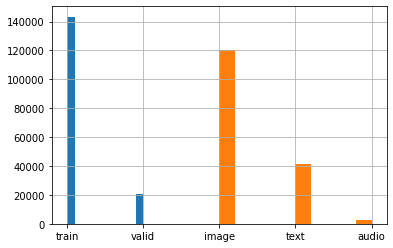

In [ ]:
#@title Распределение модальностей
df['stage'].hist(); df['modality'].hist();

In [ ]:
#@title Подготовка предобученной модели и токенизатора, а также CTC Labeling для задачи распознавания рукописного текста
CHARS = ' !"#&\'()*+,-./0123456789:;<=>?ABCDEFGHIJKLMNOPQRSTUVWXYZ' + \
    '[]_abcdefghijklmnopqrstuvwxyz|}ЁАБВГДЕЖЗИКЛМНОПРСТУФХЦЧШЩЫЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяё№'
ctc_labeling = CTCLabeling(CHARS)
gpt_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt_model = GPT2Model.from_pretrained('gpt2')

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

**Dataset**

готовим единый формат датасета для всех описанных задач и модальностей

In [ ]:
class DatasetRetriever(Dataset):

    def __init__(self, task_ids, inputs, outputs, ctc_labeling, gpt_tokenizer, task_augs=None):
        super().__init__()
        self.task_ids = task_ids
        self.inputs = inputs
        self.outputs = outputs
        self.task_augs = task_augs or {}

        # emotion[audio]:
        self.sr = 16000
        self.duration = 5

        # handwritten[image]:
        self.ctc_labeling = ctc_labeling
        self.handwritten_image_w = 512
        self.handwritten_image_h = 128

        # sentiment[text]:
        self.gpt_tokenizer = gpt_tokenizer
        self.max_length = 100
        self.n_classes = 5

    def __getitem__(self, idx):
        task_id = self.task_ids[idx]
        if task_id == 'emotion':
            return self.get_emotion_sample(idx)
        elif task_id == 'handwritten':
            return self.get_handwritten_sample(idx)
        elif task_id == 'sentiment':
            return self.get_sentiment_sample(idx)
        return {'task_id': task_id}
    
    def get_sentiment_sample(self, idx):
        text = self.inputs[idx]
        ## Augs ##
        transforms = self.task_augs.get('sentiment')
        if transforms:
            text = transforms(text=text)['text']
        ##########
        encoded = self.gpt_tokenizer.encode_plus(str(text), add_special_tokens=True)
        input_ids, attention_mask = encoded['input_ids'][:self.max_length], encoded['attention_mask'][:self.max_length]
        input_ids += [0]*(self.max_length - len(input_ids))
        attention_mask += [0]*(self.max_length - len(attention_mask))
        input_ids, attention_mask = torch.tensor(input_ids), torch.tensor(attention_mask)
        #
        label = self.outputs[idx]
        target = onehot(self.n_classes, label)
        return {
            'task_id': self.task_ids[idx],
            'target': target,
            'input_ids': input_ids, 
            'attention_mask': attention_mask,
        }

    def get_emotion_sample(self, idx):
        path = 'ravdess_16k/audio/' + self.inputs[idx]
        waveform, sample_rate = torchaudio.load(path)
        waveform = waveform.mean(0).unsqueeze(0) # to mono
        waveform = waveform[:, :self.sr*self.duration]
        ## Augs ##
        transforms = self.task_augs.get('emotion')
        if transforms:
            waveform = transforms(waveform=waveform)['waveform']
        ##########
        waveform = waveform.squeeze(0)
        waveform_length = min(waveform.shape[0], self.sr*self.duration)
        pad_waveform = torch.zeros(self.sr*self.duration, dtype=torch.float32)
        pad_waveform[:waveform_length] = waveform[:waveform_length]
        return {
            'task_id': self.task_ids[idx],
            'waveform': pad_waveform,
            'label': torch.tensor(self.outputs[idx], dtype=torch.int32),
        }

    def get_handwritten_sample(self, idx):
        path = 'handwritten/images/' + self.inputs[idx]
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image, _ = self.resize_image(image)

        gt_text = self.outputs[idx]
        encoded = self.ctc_labeling.encode(gt_text)

        ## Augs ##
        transforms = self.task_augs.get('handwritten')
        if transforms:
            image = transforms(image=image)['image']
        ##########

        image = image.astype(np.float32) / 255.0
        image = torch.from_numpy(image).permute(2, 0, 1)

        return {
            'task_id': self.task_ids[idx],
            'image': image,
            'gt_text': gt_text,
            'encoded': torch.tensor(encoded, dtype=torch.int32),
        }

    def resize_image(self, image):
        image, coef = resize_if_need(image, self.handwritten_image_h, self.handwritten_image_w)
        image = make_img_padding(image, self.handwritten_image_h, self.handwritten_image_w)
        return image, coef

 
    def __len__(self) -> int:
        return self.task_ids.shape[0]

    def get_task_labels(self):
        return list(self.task_ids)

[speechaugs](https://github.com/waveletdeboshir/speechaugs/) - библиотека для аугментации звука с api [albumentations](https://github.com/albumentations-team/albumentations), чуть подробнее посмотреть о speechаugs можно [здесь](https://github.com/waveletdeboshir/speechaugs/blob/master/examples/Augmentations_Example.ipynb)

In [ ]:
task_augs = {
    'emotion': A.Compose([
        speechaugs.ForwardTimeShift(sr=16000, max_duration=5, p=0.1),
        speechaugs.Inversion(p=0.5),
        speechaugs.ZeroSamples(max_percent=0.1, p=0.2),
    ], p=1.0),
    'handwritten': A.Compose([
        A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.25, always_apply=False),
        A.Rotate(limit=3, interpolation=1, border_mode=0, p=0.5),
        A.JpegCompression(quality_lower=75, p=0.5),
    ], p=1.0),
}

df_train = df[df['stage'] == 'train']
df_valid = df[df['stage'] == 'valid']

train_dataset = DatasetRetriever(
    task_ids=df_train['task_id'].values,
    inputs=df_train['input'].values,
    outputs=df_train['output'].values,
    ctc_labeling=ctc_labeling,
    gpt_tokenizer=gpt_tokenizer,
    task_augs=task_augs,
)
valid_dataset = DatasetRetriever(
    task_ids=df_valid['task_id'].values,
    inputs=df_valid['input'].values,
    outputs=df_valid['output'].values,
    ctc_labeling=ctc_labeling,
    gpt_tokenizer=gpt_tokenizer,
)

In [ ]:
#@title Как выглядят семплы для каждой задачи
def demo_sample(sample):
    if sample['task_id'] == 'emotion':
        print('[label]:', sample['label'].item())
        print('[waveform_shape]:', sample['waveform'].shape)
        waveform = sample['waveform']
        waveform_length = torch.where(waveform > 0)[0].max()
        return ipd.Audio(waveform[:waveform_length], rate=16000)
    elif sample['task_id'] == 'handwritten':
        print('[gt_text]:',sample['gt_text'])
        return io.imshow(sample['image'].permute(1,2,0).numpy())
    elif sample['task_id'] == 'sentiment':
        label = sample['target'].argmax().item()
        print('[sentiment]:', label2sentiment[label])
        print('[text]:', gpt_tokenizer.decode(sample['input_ids'].cpu().numpy(), skip_special_tokens=True))
        return
    return sample

In [ ]:
#@title Текстовая модальность
demo_sample(train_dataset[(train_dataset.task_ids == 'sentiment').argmax()])

[sentiment]: Extremely Negative
[text]: Consumer durables firms stare at uncertain future From rising taxation to disruption in supply and demand several factors have affected their fortunes BS reports!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


In [ ]:
#@title Аудио модальность
demo_sample(train_dataset[(train_dataset.task_ids == 'emotion').argmax()])

[label]: 1
[waveform_shape]: torch.Size([80000])


[gt_text]: всегда


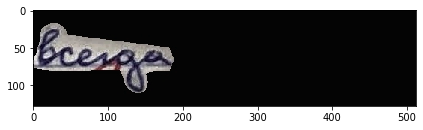

In [ ]:
#@title Картиночная модальность
demo_sample(train_dataset[(train_dataset.task_ids == 'handwritten').argmax()]);

Для корректного сбора батча предлагается модифицировать collate_fn, который может работать с семплами предложенных задач и готовить необходимые тензоры. На выходе ожидается разделение на подбатчи задач.


In [ ]:
def fb_collate_fn(batch):
    """ fusion brain collate fn """
    waveforms, labels = [], []  # emotion[audio]
    encoded, encoded_length, images, gt_texts = [], [], [], [] # handwritten[image]
    input_ids, attention_mask, targets = [], [], []  # sentiment[text]
    for i, sample in enumerate(batch):
        if sample['task_id'] == 'emotion':
            waveforms.append(sample['waveform'])
            labels.append(sample['label'])
        elif sample['task_id'] == 'handwritten':
            encoded.append(sample['encoded'])
            encoded_length.append(sample['encoded'].shape[0])
            images.append(sample['image'])
            gt_texts.append(sample['gt_text'])
        elif sample['task_id'] == 'sentiment':
            input_ids.append(sample['input_ids'])
            attention_mask.append(sample['attention_mask'])
            targets.append(sample['target'])
    if waveforms:
        waveforms, labels = pad_sequence(waveforms, batch_first=True),  torch.hstack(labels)
    if images:
        images = pad_sequence(images, batch_first=True)
        encoded, encoded_length = pad_sequence(encoded, batch_first=True), torch.tensor(encoded_length)
    if input_ids:
        input_ids = pad_sequence(input_ids, batch_first=True)
        attention_mask = pad_sequence(attention_mask, batch_first=True)
        targets = pad_sequence(targets, batch_first=True)
    return (waveforms, labels), (images, encoded, encoded_length, gt_texts), (input_ids, attention_mask, targets)

Для проведения экспериментов используется маленькая версия GPT2, предлагается попробовать модели с бОльшим количеством параметров, а также русскоязычную модель [RuGPT3](https://github.com/sberbank-ai/ru-gpts) от Sberbank

In [ ]:
class GPT2FusionBrain(nn.Module):

    def __init__(self, gpt_model, emotion_config, handwritten_config, sentiment_config, **freeze_gpt_kwargs):
        super().__init__()
        self.gpt_model = gpt_model
        self.embedding_size = self.gpt_model.embed_dim
        self.freeze_gpt(**freeze_gpt_kwargs)

        # emotion[audio] input/output layers:
        self.emotion_config = emotion_config
        self.mel_spec = torchaudio.transforms.MelSpectrogram(
            sample_rate=emotion_config['sample_rate'], 
            n_fft=emotion_config['n_fft'],
        )
        self.a2db = torchaudio.transforms.AmplitudeToDB()
        self.emotion_input_layer = self._build_input_net(
            input_dim=emotion_config['patch_w']*emotion_config['patch_h'],
            in_layer_sizes=emotion_config['in_layer_sizes'],
            orth_gain=emotion_config['orth_gain'],
            dropout=emotion_config['dropout'],
        )
        self.emotion_output_layer = self._build_output_net(
            output_dim=emotion_config['output_dim'],
            out_layer_sizes=emotion_config['out_layer_sizes'],
            dropout=emotion_config['dropout'],
            embedding_size=self.embedding_size*2,
        )
        print('=== EMOTION TASK ===')
        self._calculate_trainable_params([
            self.mel_spec,
            self.a2db, 
            self.emotion_input_layer,
            self.gpt_model, 
            self.emotion_output_layer
        ])
        print('=== === === === ===')
        #####

        # handwritten[image] input/output layers:
        self.handwritten_config = handwritten_config
        self.handwritten_input_layer = self._build_input_net(
            input_dim=handwritten_config['patch_w']*handwritten_config['patch_h']*3,
            in_layer_sizes=handwritten_config['in_layer_sizes'],
            orth_gain=handwritten_config['orth_gain'],
            dropout=handwritten_config['dropout'],
        )
        self.handwritten_lstm = nn.LSTM(
            self.embedding_size, self.embedding_size // 2,
            handwritten_config['lstm_num_layers'], dropout=handwritten_config['dropout'],
            batch_first=True, bidirectional=True
        )
        self.handwritten_output_layer = self._build_output_net(
            output_dim=handwritten_config['output_dim'],
            out_layer_sizes=handwritten_config['out_layer_sizes'],
            dropout=handwritten_config['dropout'],
        )
        print('=== HANDWRITTEN TASK ===')
        self._calculate_trainable_params([
            self.handwritten_input_layer,
            self.gpt_model, 
            self.handwritten_lstm, 
            self.handwritten_output_layer,
        ])
        print('=== === === === ===')
        #####

        # sentiment[text] input/output layers:
        self.sentiment_config = sentiment_config
        self.sentiment_output_layer = self._build_output_net(
            output_dim=sentiment_config['output_dim'],
            out_layer_sizes=sentiment_config['out_layer_sizes'],
            dropout=sentiment_config['dropout'],
            embedding_size=self.embedding_size*2,
        )
        print('=== SENTIMENT TASK ===')
        self._calculate_trainable_params([self.gpt_model, self.sentiment_output_layer])
        print('=== === === === ===')
        #####

        print('=== COMMON PARAMS ===')
        self._calculate_common_params()
        print('=== === === === ===')


    def forward(self, task_id, **kwargs):
        if task_id == 'emotion':
            return self.forward_emotion(**kwargs)
        elif task_id == 'handwritten':
            return self.forward_handwritten(**kwargs)
        elif task_id == 'sentiment':
            return self.forward_sentiment(**kwargs)

    def forward_sentiment(self, input_ids, attention_mask):
        transformer_outputs = self.gpt_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True,
        )
        x = transformer_outputs.last_hidden_state
        apool = torch.mean(x, 1)
        mpool, _ = torch.max(x, 1)
        x = torch.cat((apool, mpool), 1)
        x = self.sentiment_output_layer(x)
        return x 

    def forward_handwritten(self, images):
        x = rearrange(images, 'b c (h p1) (w p2) -> b (w) (h) (p1 p2 c)',
                      p1=self.handwritten_config['patch_h'], p2=self.handwritten_config['patch_w'])
        x = x.squeeze(2)
        x = self.handwritten_input_layer(x)
        # Fusion Brain
        transformer_outputs = self.gpt_model(inputs_embeds=x, return_dict=True)
        x = transformer_outputs.last_hidden_state
        #####
        x, _ = self.handwritten_lstm(x)        
        x = self.handwritten_output_layer(x)
        return x

    def forward_emotion(self, waveforms):
        specgrams = self.mel_spec(waveforms)
        specgrams = self.a2db(specgrams).unsqueeze(1)
        # Masking Augs:
        if self.training:
            if random.random() > 0.5:
                for _ in range(random.randint(1,5)):
                    f_masking = torchaudio.transforms.FrequencyMasking(
                        freq_mask_param=random.choice([4,6,8]),
                        iid_masks=True
                    )
                    specgrams = f_masking(specgrams)
        #####
        x = rearrange(specgrams, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', 
                      p1=self.emotion_config['patch_h'], p2=self.emotion_config['patch_w'])
        x = self.emotion_input_layer(x)

        # Fusion Brain
        transformer_outputs = self.gpt_model(inputs_embeds=x, return_dict=True)
        x = transformer_outputs.last_hidden_state
        #####

        apool = torch.mean(x, 1)
        mpool, _ = torch.max(x, 1)
        x = torch.cat((apool, mpool), 1)
        x = self.emotion_output_layer(x)
        return x 

    def freeze_gpt(self, freeze_pos=True, freeze_ln=True, freeze_attn=True, freeze_ff=True, freeze_other=True):
        for name, p in self.gpt_model.named_parameters():
            name = name.lower()
            if 'ln' in name or 'norm' in name:
                p.requires_grad = not freeze_ln
            elif 'wpe' in name or 'position_embeddings' in name or 'pos_drop' in name:
                p.requires_grad = not freeze_pos
            elif 'mlp' in name:
                p.requires_grad = not freeze_ff
            elif 'attn' in name:
                p.requires_grad = not freeze_attn
            else:
                p.requires_grad = not freeze_other

    def _build_input_net(self, input_dim, in_layer_sizes=None, orth_gain=1.41, dropout=0.1):
        """ вспомогательный метод для сборки input слоя, который приводит размер входящих данный к эмбеддингу gpt """
        in_layer_sizes = [] if not in_layer_sizes else in_layer_sizes
        in_layers = []
        last_output_size = input_dim
        for size in in_layer_sizes:
            layer = nn.Linear(last_output_size, size)
            if orth_gain is not None:
                torch.nn.init.orthogonal_(layer.weight, gain=orth_gain)
            layer.bias.data.zero_()

            in_layers.append(layer)
            in_layers.append(nn.ReLU())
            in_layers.append(nn.Dropout(dropout))
            last_output_size = size

        final_linear = nn.Linear(last_output_size, self.embedding_size)
        if orth_gain is not None:
            torch.nn.init.orthogonal_(final_linear.weight, gain=orth_gain)
        final_linear.bias.data.zero_()

        in_layers.append(final_linear)
        in_layers.append(nn.Dropout(dropout))

        return nn.Sequential(*in_layers)
    
    def _build_output_net(self, output_dim, embedding_size=None, out_layer_sizes=None, dropout=0.1):
        """ вспомогательный метод для сборки output слоя """
        out_layer_sizes = [] if not out_layer_sizes else out_layer_sizes
        out_layers = []
        last_output_size = embedding_size or self.embedding_size
        for size in out_layer_sizes:
            out_layers.append(nn.Linear(last_output_size, size))
            out_layers.append(nn.ReLU())
            out_layers.append(nn.Dropout(dropout))
            last_output_size = size
        out_layers.append(nn.Linear(last_output_size, output_dim))
        return nn.Sequential(*out_layers)

    def _calculate_trainable_params(self, layers):
        trainable_params, all_used_params = 0, 0
        for layer in layers:
            trainable_params += sum(p.numel() for p in layer.parameters() if p.requires_grad)
            all_used_params += sum(p.numel() for p in layer.parameters())        
        print('trainable_params:', trainable_params)
        print(' all_used_params:', all_used_params)
        print('               %:', round(trainable_params/all_used_params*100, 2))

    def _calculate_common_params(self):
        all_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        common_params = sum(p.numel() for p in self.gpt_model.parameters())
        print('common_params:', common_params)
        print('   all_params:', all_params)
        print('            %:', round(common_params/all_params*100, 2))     
        print('trainable_params:', trainable_params)
        print('               %:', round(trainable_params/all_params*100, 2))

In [ ]:
emotion_config = {
    'sample_rate': 16000,
    'n_fft': 627,
    'patch_w': 16,
    'patch_h': 128,
    'in_layer_sizes': [],
    'out_layer_sizes': [],
    'orth_gain': 1.41,
    'dropout': 0.1,
    'output_dim': 8,
}

handwritten_config = {
    'patch_w': 8,
    'patch_h': 128,
    'in_layer_sizes': [8*128*3],
    'out_layer_sizes': [64],
    'orth_gain': 1.41,
    'dropout': 0.1,
    'lstm_num_layers': 3,
    'output_dim': len(ctc_labeling), # 152
}

sentiment_config = {
    'out_layer_sizes': [768],
    'dropout': 0.1,
    'output_dim': 5,
}

model = GPT2FusionBrain(
    gpt_model, 
    emotion_config=emotion_config,
    handwritten_config=handwritten_config,
    sentiment_config=sentiment_config,
)

=== EMOTION TASK ===
trainable_params: 1585928
 all_used_params: 126025736
               %: 1.26
=== === === === ===
=== HANDWRITTEN TASK ===
trainable_params: 22494680
 all_used_params: 146934488
               %: 15.31
=== === === === ===
=== SENTIMENT TASK ===
trainable_params: 1184261
 all_used_params: 125624069
               %: 0.94
=== === === === ===
=== COMMON PARAMS ===
common_params: 124439808
   all_params: 149704677
            %: 83.12
trainable_params: 25264869
               %: 16.88
=== === === === ===


In [ ]:
#@title Скрипты для обучения и оценки качества модели


class FusionBrainExperiment(TorchGPUExperiment):

    emotion_criterion = torch.nn.CrossEntropyLoss()
    handwritten_criterion = torch.nn.CTCLoss(zero_infinity=True)
    sentiment_criterion = LabelSmoothing()
    ctc_labeling = ctc_labeling

    def calculate_handwritten_metrics(self, gt_texts, outputs):
        pred_texts = []
        for encoded in outputs.argmax(2).data.cpu().numpy():
            pred_texts.append(self.ctc_labeling.decode(encoded))
        texts = [self.ctc_labeling.preprocess(text) for text in gt_texts]
        return {
            'h_cer': cer(pred_texts, texts),
            'h_wer': wer(pred_texts, texts),
            'h_acc': string_accuracy(pred_texts, texts),
        }

    def handle_one_batch(self, batch):
        (waveforms, labels), (images, encoded, encoded_length, gt_texts), (input_ids, attention_mask, targets) = batch
        sum_bs = len(waveforms) + len(images) + len(input_ids)
        losses = []
        metrics = {}
        if len(waveforms) > 0:
            bs = waveforms.shape[0]
            waveforms = waveforms.to(self.device, dtype=torch.float32)
            labels = labels.to(self.device, dtype=torch.int64)
            emotion_outputs = self.model('emotion', waveforms=waveforms)
            emotion_loss = self.emotion_criterion(emotion_outputs, labels)
            metrics['e_acc'] = acc(labels, emotion_outputs)
            metrics['e_loss'] = emotion_loss.detach().cpu().item()
            losses.append(emotion_loss)

        if len(images) > 0:
            bs = images.shape[0]
            images = images.to(self.device, dtype=torch.float32)
            encoded_length = encoded_length.to(self.device, dtype=torch.int32)
            encoded = encoded.to(self.device, dtype=torch.int32)
            handwritten_outputs = self.model('handwritten', images=images)
            preds_size = torch.IntTensor([handwritten_outputs.size(1)] * bs)
            preds = handwritten_outputs.log_softmax(2).permute(1, 0, 2)
            handwritten_loss = self.handwritten_criterion(preds, encoded, preds_size, encoded_length)
            handwritten_metrics = self.calculate_handwritten_metrics(gt_texts, handwritten_outputs)
            metrics.update(handwritten_metrics)
            metrics['h_loss'] = handwritten_loss.detach().cpu().item()
            losses.append(handwritten_loss)

        if len(input_ids) > 0:
            bs = input_ids.shape[0]
            input_ids = input_ids.to(self.device, dtype=torch.long) 
            attention_mask = attention_mask.to(self.device, dtype=torch.long) 
            targets = targets.to(self.device, dtype=torch.float) 
            sentiment_outputs = self.model('sentiment', input_ids=input_ids, attention_mask=attention_mask)
            sentiment_loss = self.sentiment_criterion(sentiment_outputs, targets)
            metrics['s_acc'] = acc(targets.argmax(axis=1), sentiment_outputs)
            metrics['s_loss'] = sentiment_loss.detach().cpu().item()
            losses.append(sentiment_loss)

        loss = sum(losses)
        self.metrics.update(loss=loss.detach().cpu().item(), **metrics)

        if self.is_train:
            loss.backward()
            self.optimizer_step()
            self.optimizer.zero_grad()
            self.scheduler.step()


def run_evaluation(loader, model, device=torch.device('cuda:0')):
    result = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for batch in tqdm(loader):
            (waveforms, labels), (images, encoded, encoded_length, gt_texts), (input_ids, attention_mask, targets) = batch
            if len(waveforms) > 0:
                waveforms = waveforms.to(device, dtype=torch.float32)
                emotion_outputs = model('emotion', waveforms=waveforms)        
                for label, pred_label in zip(labels.cpu().numpy(), emotion_outputs.argmax(1).cpu().numpy()):
                    result.append({
                        'task_id': 'emotion',
                        'gt_output': label,
                        'pred_output': pred_label,
                    })

            if len(images) > 0:
                images = images.to(device, dtype=torch.float32)
                handwritten_outputs = model('handwritten', images=images)
                for encoded, gt_text in zip(handwritten_outputs.argmax(2).data.cpu().numpy(), gt_texts):
                    pred_text = ctc_labeling.decode(encoded)
                    result.append({
                        'task_id': 'handwritten',
                        'gt_output': gt_text,
                        'pred_output': pred_text,
                    })

            if len(input_ids) > 0:
                input_ids = input_ids.to(device, dtype=torch.long) 
                attention_mask = attention_mask.to(device, dtype=torch.long) 
                sentiment_outputs = model('sentiment', input_ids=input_ids, attention_mask=attention_mask)
                for label, pred_label in zip(targets.argmax(axis=1).cpu().numpy(), sentiment_outputs.argmax(1).cpu().numpy()):
                    result.append({
                        'task_id': 'sentiment',
                        'gt_output': label,
                        'pred_output': pred_label,
                    })

    result = pd.DataFrame(result)

    emotion_result = result[result['task_id'] == 'emotion']
    print('\n')
    if emotion_result.shape[0]:
        print('=== Emotion ===')
        print('ACC:', round(accuracy_score(emotion_result['gt_output'].astype(int), emotion_result['pred_output'].astype(int)), 3))
        print('=== === === ===')

    handwritten_result = result[result['task_id'] == 'handwritten']
    if handwritten_result.shape[0]:
        print('= Handwritten =')
        print('CER:', round(cer(handwritten_result['pred_output'], handwritten_result['gt_output']), 3))
        print('WER:', round(wer(handwritten_result['pred_output'], handwritten_result['gt_output']), 3))
        print('ACC:', round(string_accuracy(handwritten_result['pred_output'], handwritten_result['gt_output']), 3))
        print('=== === === ===')

    sentiment_result = result[result['task_id'] == 'sentiment']
    if sentiment_result.shape[0]:
        print('== Sentiment ==')
        print('ACC:', round(accuracy_score(sentiment_result['gt_output'].astype(int), sentiment_result['pred_output'].astype(int)), 3))
        print('=== === === ===')

    return result


def load_model(model, experiment_name):
    paths = sorted(glob(f'./saved_models/{experiment_name}*'))
    if len(paths) == 0:
        print('Warning! Model not found')
        return model
    checkpoint_path = paths[-1] + '/last.pt'
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    model.load_state_dict(checkpoint['model_state_dict'])
    metrics = defaultdict(list)
    for epoch in range(len(checkpoint['metrics_state_dict']['train_metrics'])):
        train_metrics = checkpoint['metrics_state_dict']['train_metrics'][epoch]['avg']
        valid_metrics = checkpoint['metrics_state_dict']['valid_metrics'][epoch]['avg']
        for key in train_metrics.keys():
            metrics[f'train_{key}'].append(train_metrics[key])
            metrics[f'valid_{key}'].append(valid_metrics[key])
        metrics['epoch'].append(epoch)        
    metrics = pd.DataFrame(metrics)
    return model, metrics

# Эксперименты

поскольку требуемое количество итераций и количество уникальных семплов в выбранных задачах сильно различаются, то предлагается сначала выполнить "каскадное" обучение задач по отдельности. 

1. Обучим задачу sentiment[text], заморозив у gpt все слои (~1% обучаемых параметров)
2. Затем обучим задачу emotion[audio] также с замороженными слоями gpt (~1% обучаемых параметров), ожидаем, что языковая GPT2 справится с аудио модальностью (FusionBrain)
3. После обучим задачу handwritten[image] также с замороженными слоями gpt (~15% обучаемых параметров), ожидаем, что языковая GPT2 справится с картиночной модальностью (FusionBrain)
4. Проведем оценку качества на всех задачах
5. Разморозим все слои gpt и выполним дообучение на всех модальностях одновременно с балансировкой сэмплирования по задачам (~100% обучаемых параметров)
6. Проведем новую оценку качества на всех задачах, ожидаем некий прирост за счет мультимодальности и мультизадачности при разморозке общих используемых слоев (FusionBrain)



In [ ]:
# @title Запуск обучения sentiment[text]

DEMO_LOGS = True #@param {type:"boolean"}

sentiment_train = df[(df['task_id'] == 'sentiment') & (df['stage'] == 'train')]
sentiment_valid = df[(df['task_id'] == 'sentiment') & (df['stage'] == 'valid')]

sentiment_train_dataset = DatasetRetriever(
    task_ids=sentiment_train['task_id'].values,
    inputs=sentiment_train['input'].values,
    outputs=sentiment_train['output'].values,
    ctc_labeling=ctc_labeling,
    gpt_tokenizer=gpt_tokenizer,
    task_augs=task_augs,
)
sentiment_valid_dataset = DatasetRetriever(
    task_ids=sentiment_valid['task_id'].values,
    inputs=sentiment_valid['input'].values,
    outputs=sentiment_valid['output'].values,
    ctc_labeling=ctc_labeling,
    gpt_tokenizer=gpt_tokenizer,
)

model.freeze_gpt()

CONFIG = {
    'description': 'Обучение sentiment task',
    'experiment_name': f'fusion-brain-sentiment-{round(datetime.utcnow().timestamp())}',
    'lr': 0.00008,
    'bs': 32,
    'num_epochs': 25,
    'max_lr': 0.001,
    'pct_start': 0.1,
}

device = torch.device('cuda:0')

train_loader = torch.utils.data.DataLoader(
    sentiment_train_dataset,
    batch_size=CONFIG['bs'],
    sampler=RandomSampler(sentiment_train_dataset),
    pin_memory=False,
    drop_last=True,
    num_workers=2,
    collate_fn=fb_collate_fn,
)
valid_loader = torch.utils.data.DataLoader(
    sentiment_valid_dataset,
    batch_size=CONFIG['bs'],
    sampler=SequentialSampler(sentiment_valid_dataset),
    pin_memory=False,
    drop_last=False,
    num_workers=2,
    collate_fn=fb_collate_fn,
)

model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['lr'])
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=CONFIG['max_lr'],
    steps_per_epoch=len(train_loader), 
    pct_start=CONFIG['pct_start'],
    epochs=CONFIG['num_epochs'],
)

if DEMO_LOGS:
    print(open('./saved_models/fusion-brain-sentiment-1631794561/log.txt').read())
else:
    experiment = FusionBrainExperiment(
        model=model,
        optimizer=optimizer,
        criterion=None,
        scheduler=scheduler,
        device=device,
        base_dir=f'./saved_models',
        experiment_name=CONFIG['experiment_name'],
        verbose_step=10**5,
        seed=42,
        best_saving=False,
        last_saving=True,
    )
    experiment.fit(train_loader, valid_loader, CONFIG['num_epochs'])
    experiment.destroy()

100%|██████████| 647/647 [02:00<00:00,  5.38it/s]




=== Emotion ===
ACC: 0.147
=== === === ===
= Handwritten =
CER: 1.118
WER: 1.0
ACC: 0.0
=== === === ===
== Sentiment ==
ACC: 0.484
=== === === ===


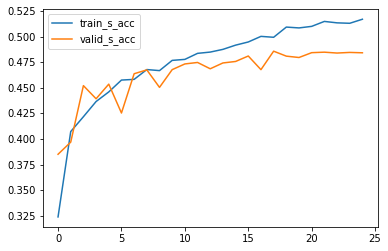

In [ ]:
#@title Промежуточный evaluation

model, metrics = load_model(model, 'fusion-brain-sentiment')
model = model.to(device)

valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=32,
    sampler=SequentialSampler(valid_dataset),
    pin_memory=False,
    drop_last=False,
    num_workers=2,
    collate_fn=fb_collate_fn,
)

evaluation_result = run_evaluation(valid_loader, model)
metrics[['train_s_acc', 'valid_s_acc']].plot();

In [ ]:
# @title Запуск обучения emotion[audio]

DEMO_LOGS = True #@param {type:"boolean"}


emotion_train = df[(df['task_id'] == 'emotion') & (df['stage'] == 'train')]
emotion_valid = df[(df['task_id'] == 'emotion') & (df['stage'] == 'valid')]

emotion_train_dataset = DatasetRetriever(
    task_ids=emotion_train['task_id'].values,
    inputs=emotion_train['input'].values,
    outputs=emotion_train['output'].values,
    ctc_labeling=ctc_labeling,
    gpt_tokenizer=gpt_tokenizer,
    task_augs=task_augs,
)
emotion_valid_dataset = DatasetRetriever(
    task_ids=emotion_valid['task_id'].values,
    inputs=emotion_valid['input'].values,
    outputs=emotion_valid['output'].values,
    ctc_labeling=ctc_labeling,
    gpt_tokenizer=gpt_tokenizer,
)

CONFIG = {
    'description': 'Обучение emotion task',
    'experiment_name': f'fusion-brain-emotion-{round(datetime.utcnow().timestamp())}',
    'lr': 0.00008,
    'bs': 8,
    'num_epochs': 50,
    'max_lr': 0.0015,
    'pct_start': 0.1,
}

device = torch.device('cuda:0')

train_loader = torch.utils.data.DataLoader(
    emotion_train_dataset,
    batch_size=CONFIG['bs'],
    sampler=RandomSampler(emotion_train_dataset),
    pin_memory=False,
    drop_last=True,
    num_workers=2,
    collate_fn=fb_collate_fn,
)
valid_loader = torch.utils.data.DataLoader(
    emotion_valid_dataset,
    batch_size=CONFIG['bs'],
    sampler=SequentialSampler(emotion_valid_dataset),
    pin_memory=False,
    drop_last=False,
    num_workers=2,
    collate_fn=fb_collate_fn,
)

model, _ = load_model(model, 'fusion-brain-sentiment')
model.freeze_gpt()
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['lr'])
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=CONFIG['max_lr'],
    steps_per_epoch=len(train_loader), 
    pct_start=CONFIG['pct_start'],
    epochs=CONFIG['num_epochs'],
)

if DEMO_LOGS:
    print(open('./saved_models/fusion-brain-emotion-1631796786/log.txt').read())
else:
    experiment = FusionBrainExperiment(
        model=model,
        optimizer=optimizer,
        criterion=None,
        scheduler=scheduler,
        device=device,
        base_dir=f'./saved_models',
        experiment_name=CONFIG['experiment_name'],
        verbose_step=10**5,
        seed=42,
        best_saving=False,
        last_saving=True,
    )
    experiment.fit(train_loader, valid_loader, CONFIG['num_epochs'])
    experiment.destroy()

100%|██████████| 647/647 [02:05<00:00,  5.14it/s]




=== Emotion ===
ACC: 0.642
=== === === ===
= Handwritten =
CER: 1.118
WER: 1.0
ACC: 0.0
=== === === ===
== Sentiment ==
ACC: 0.484
=== === === ===


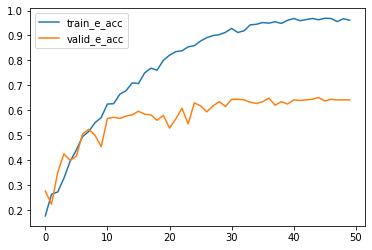

In [ ]:
#@title Промежуточный evaluation

model, metrics = load_model(model, 'fusion-brain-emotion')
model = model.to(device)

valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=32,
    sampler=SequentialSampler(valid_dataset),
    pin_memory=False,
    drop_last=False,
    num_workers=2,
    collate_fn=fb_collate_fn,
)

evaluation_result = run_evaluation(valid_loader, model)
metrics[['train_e_acc', 'valid_e_acc']].plot();

**Handwritten** 

обучение картиночной модальности на задаче распознавания рукописного текста. заморозим GPT2 полностью. <20% обучаемых параметров

In [ ]:
# @title Запуск обучения handwritten[image]

DEMO_LOGS = True #@param {type:"boolean"}

handwritten_train = df[(df['task_id'] == 'handwritten') & (df['stage'] == 'train')]
handwritten_valid = df[(df['task_id'] == 'handwritten') & (df['stage'] == 'valid')]

handwritten_train_dataset = DatasetRetriever(
    task_ids=handwritten_train['task_id'].values,
    inputs=handwritten_train['input'].values,
    outputs=handwritten_train['output'].values,
    ctc_labeling=ctc_labeling,
    gpt_tokenizer=gpt_tokenizer,
    task_augs=task_augs,
)
handwritten_valid_dataset = DatasetRetriever(
    task_ids=handwritten_valid['task_id'].values,
    inputs=handwritten_valid['input'].values,
    outputs=handwritten_valid['output'].values,
    ctc_labeling=ctc_labeling,
    gpt_tokenizer=gpt_tokenizer,
)

CONFIG = {
    'description': 'Обучение handwritten task',
    'experiment_name': f'fusion-brain-handwritten-{round(datetime.utcnow().timestamp())}',
    'lr': 0.00008,
    'bs': 32,
    'num_epochs': 150,
    'max_lr': 0.001,
    'pct_start': 0.1,
}

device = torch.device('cuda:0')

train_loader = torch.utils.data.DataLoader(
    handwritten_train_dataset,
    batch_size=CONFIG['bs'],
    sampler=RandomSampler(handwritten_train_dataset),
    pin_memory=False,
    drop_last=True,
    num_workers=2,
    collate_fn=fb_collate_fn,
)
valid_loader = torch.utils.data.DataLoader(
    handwritten_valid_dataset,
    batch_size=CONFIG['bs'],
    sampler=SequentialSampler(handwritten_valid_dataset),
    pin_memory=False,
    drop_last=False,
    num_workers=2,
    collate_fn=fb_collate_fn,
)

model, _ = load_model(model, 'fusion-brain-emotion')
model.freeze_gpt()
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['lr'])
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=CONFIG['max_lr'],
    steps_per_epoch=len(train_loader), 
    pct_start=CONFIG['pct_start'],
    epochs=CONFIG['num_epochs'],
)

if DEMO_LOGS:
    print(open('./saved_models/fusion-brain-handwritten-1631797524/log.txt').read())
else:
    experiment = FusionBrainExperiment(
        model=model,
        optimizer=optimizer,
        criterion=None,
        scheduler=scheduler,
        device=device,
        base_dir=f'./saved_models',
        experiment_name=CONFIG['experiment_name'],
        verbose_step=10**5,
        seed=42,
        best_saving=False,
        last_saving=True,
    )
    experiment.fit(train_loader, valid_loader, CONFIG['num_epochs'])
    experiment.destroy()

**Evaluation** 

после обучения отдельных модальностей

100%|██████████| 647/647 [02:07<00:00,  5.07it/s]




=== Emotion ===
ACC: 0.642
=== === === ===
= Handwritten =
CER: 0.121
WER: 0.334
ACC: 0.669
=== === === ===
== Sentiment ==
ACC: 0.485
=== === === ===


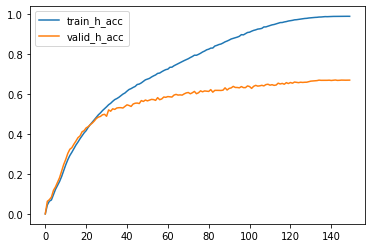

In [ ]:
#@title Промежуточный evaluation

model, metrics = load_model(model, 'fusion-brain-handwritten')
model = model.to(device)

valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=32,
    sampler=SequentialSampler(valid_dataset),
    pin_memory=False,
    drop_last=False,
    num_workers=2,
    collate_fn=fb_collate_fn,
)

evaluation_result = run_evaluation(valid_loader, model)
metrics[['train_h_acc', 'valid_h_acc']].plot();

**Fusion Brain**

In [ ]:
# @title Запуск обучения fusion brain [text,audio,image]

DEMO_LOGS = True #@param {type:"boolean"}

CONFIG = {
    'description': 'Fusion Brain',
    'experiment_name': f'fusion-brain-main-{round(datetime.utcnow().timestamp())}',
    'lr': 0.00008,
    'bs': 32,
    'num_epochs': 100,
    'max_lr': 0.00004,
    'pct_start': 0.1,
    'final_div_factor': 100
}

device = torch.device('cuda:0')

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=CONFIG['bs'],
    sampler=BalanceClassSampler(labels=train_dataset.get_task_labels()),
    pin_memory=False,
    drop_last=True,
    num_workers=2,
    collate_fn=fb_collate_fn,
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=CONFIG['bs'],
    sampler=BalanceClassSampler(labels=valid_dataset.get_task_labels()),
    pin_memory=False,
    drop_last=False,
    num_workers=2,
    collate_fn=fb_collate_fn,
)

model, _ = load_model(model, 'fusion-brain-handwritten')
model.freeze_gpt(False, False, False, False, False)
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['lr'])
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=CONFIG['max_lr'],
    steps_per_epoch=len(train_loader), 
    pct_start=CONFIG['pct_start'],
    epochs=CONFIG['num_epochs'],
    final_div_factor=CONFIG['final_div_factor'],
)

if DEMO_LOGS:
    print(open('./saved_models/fusion-brain-main-1631924391/log.txt').read())
else:
    experiment = FusionBrainExperiment(
        model=model,
        optimizer=optimizer,
        criterion=None,
        scheduler=scheduler,
        device=device,
        base_dir=f'./saved_models',
        experiment_name=CONFIG['experiment_name'],
        verbose_step=10**5,
        seed=42,
        best_saving=False,
        last_saving=True,
    )
    experiment.fit(train_loader, valid_loader, CONFIG['num_epochs'])
    experiment.destroy()

100%|██████████| 647/647 [02:06<00:00,  5.12it/s]




=== Emotion ===
ACC: 0.651
=== === === ===
= Handwritten =
CER: 0.122
WER: 0.337
ACC: 0.665
=== === === ===
== Sentiment ==
ACC: 0.828
=== === === ===


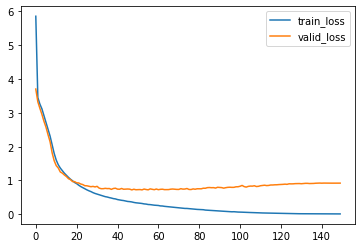

In [ ]:
#@title Final Evaluation

model, _ = load_model(model, 'fusion-brain-main')
model = model.to(device)

valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=32,
    sampler=SequentialSampler(valid_dataset),
    pin_memory=False,
    drop_last=False,
    num_workers=2,
    collate_fn=fb_collate_fn,
)

evaluation_result = run_evaluation(valid_loader, model)
metrics[['train_loss', 'valid_loss']].plot();

# Результаты

```
=== Emotion ===
ACC: 0.642 --> 0.651
=== === === ===
= Handwritten =
CER: 0.121 --> 0.122
WER: 0.334 --> 0.337
ACC: 0.669 --> 0.665
=== === === ===
== Sentiment ==
ACC: 0.485 --> 0.828
=== === === ===
```

Кажется, что удалось совместить задачи/модальности почти без потери качества в единой архитектуре (~80% общих параметров). Улучшения метрик могут быть связаны с увеличением количества обучаемых параметров после разморозки, а также с тем, что модель могла быть не до конца обучена. Для оценки вклада непосредственно от мультимодального обучения можно сравниться с обучением задач по-отдельности при полной разморозке GPT2 и таком же суммарном числе итераций.

# Идеи:

+ Multi-Modality Cross Attention - для смешивания нескольких типов модальностей в одной task_id (VQA,Z-OD)
+ ruGPT3 - попробовать другие версии backbones GPT2, а также ruGPT3
+ применить мультимодальные модели CLIP, UNIT, DALL-E
+ развивать концепции FPT (Frozen Pretrained Transformer)
+ применить Perceiver для некой унификации входных модальностей
+ попробовать Sampler, который сбалансирует минибатч по task_id
+ подобрать некие коэффициенты для взвешивания loss по отдельным задачам ?
